# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Instalar dependencias

In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Cargado de bibliotecas

In [17]:
# Datos
import numpy as np
import pandas as pd

# Preprocesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Metricas
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, make_scorer, f1_score

### Modo Testing o Kaggle

In [3]:
TESTING = True

### Cargado de Dataset

In [4]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')

#### Trabajo sobre nulos

In [5]:
# Trabajo sobre valores nulos
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

#### Transformacion de variables categoricas

In [6]:
# Transformacion de variables categoricas

import string

# encoding ordinal

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 3},
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)

In [7]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

#### Separacion de datos

In [8]:
# Definicion de excluidos y target

excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]

### Definicion de la funcion de metricas

In [9]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Generacion del dataset de prueba

In [10]:
# Separamos conjunto de Train y Test
x = ds[features].values
y = ds[target].values
x_predict = ds_test[features].values

if TESTING:
    x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state=0, stratify=ds[target])
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.10, random_state=0, stratify=ds[target])

### Escalado

In [11]:
# Vimos que el StandardScaler funciona mejor que el MinMaxScaler al entrenar la red
sscaler=StandardScaler()
sscaler.fit(x_train)
x_train = sscaler.transform(x_train)
x_test = sscaler.transform(x_test)
if not TESTING: x_predict = sscaler.transform(x_predict)
    
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.005841,-1.629843,0.789827,0.721923,-0.655316,0.074218,0.259688,0.227687,-0.256998,-0.081175,...,2.398055,2.590625,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,-0.167905,-0.228418,1.909289
1,1.242850,1.192710,-0.836485,-0.757367,1.390447,1.080018,0.789056,0.227687,4.838575,-0.081175,...,2.991698,2.590625,4.751219,-0.445401,-0.035953,-0.14259,1.550105,0.118103,-0.228418,0.617433
2,-1.014465,-1.629843,1.440352,1.461568,0.253912,-0.931583,-0.269681,0.227687,-0.256998,-0.081175,...,-0.570159,0.959702,4.751219,-0.445401,-0.035953,-0.14259,-0.222254,-0.868129,-0.228418,0.617433
3,-0.608148,-1.629843,0.139302,0.204172,0.935833,0.074218,-0.269681,0.227687,-0.256998,-0.081175,...,-0.570159,-0.671221,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,0.516792,-0.228418,-0.674424
4,0.520509,-0.218566,0.464565,0.500030,0.253912,-0.931583,0.259688,0.227687,-0.256998,-0.081175,...,-0.570159,-0.671221,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,0.124398,-0.228418,0.617433


### Modelo

#### Creacion del modelo

In [12]:
inputs = len(pd.DataFrame(x_train).columns)
cant_clases = len(np.unique(y_train))
max_neuronas = 64


# Usamos Early Stopping para prevenir overfitting durante el entrenamiento
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
)


# Probamos con funciones de activacion sigmoid y relu y obtuvimos mejores resultados usando relu
# Probamos 
# Tambien estamos usando DropOut para prevenir overfitting
modelo = keras.Sequential([
    keras.layers.Dense(max_neuronas,input_shape=(inputs,), activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//6, activation='relu'),
    keras.layers.Dense(max_neuronas, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #keras.layers.Dense(1, activation='sigmoid')
    keras.layers.Dense(cant_clases, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelo.compile(
  optimizer=optimizer,
  #loss='mse', 
  #loss=tf.losses.BinaryCrossentropy(),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

2023-05-26 00:14:01.351455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Entrenamiento del modelo

In [13]:
epochs = 100
batch_size = 32

history = modelo.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test,y_test),
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/100
1543/1543 [==============================] - 2s 843us/step - loss: 0.4621 - accuracy: 0.7606 - val_loss: 0.4259 - val_accuracy: 0.7789
Epoch 2/100
1543/1543 [==============================] - 1s 743us/step - loss: 0.4189 - accuracy: 0.7894 - val_loss: 0.4134 - val_accuracy: 0.7895
Epoch 3/100
1543/1543 [==============================] - 1s 751us/step - loss: 0.4067 - accuracy: 0.7961 - val_loss: 0.4015 - val_accuracy: 0.7972
Epoch 4/100
1543/1543 [==============================] - 1s 759us/step - loss: 0.4005 - accuracy: 0.8013 - val_loss: 0.4003 - val_accuracy: 0.7989
Epoch 5/100
1543/1543 [==============================] - 1s 754us/step - loss: 0.3949 - accuracy: 0.8057 - val_loss: 0.3954 - val_accuracy: 0.7999
Epoch 6/100
1543/1543 [==============================] - 1s 760us/step - loss: 0.3898 - accuracy: 0.8082 - val_loss: 0.3962 - val_accuracy: 0.8044
Epoch 7/100
1543/1543 [==============================] - 1s 754us/step - loss: 0.3848 - accuracy: 0.8100 - val_loss: 0

### Metricas del modelo

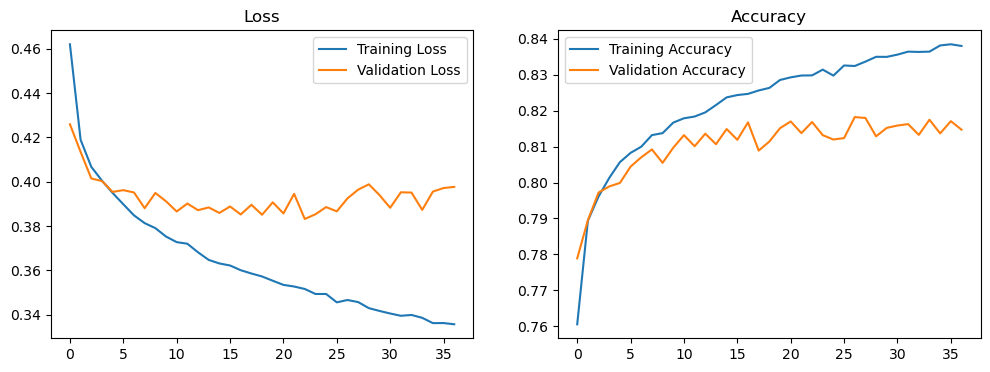

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Podemos obsservar que tanto en el entrenamiento como en la validación del modelo, la precision y la curva de perdida van a la par, lo que indica que el modelo no sufre de "overfiting" ni "underfiting".

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      6170
           1       0.83      0.80      0.81      6173

    accuracy                           0.82     12343
   macro avg       0.82      0.82      0.82     12343
weighted avg       0.82      0.82      0.82     12343



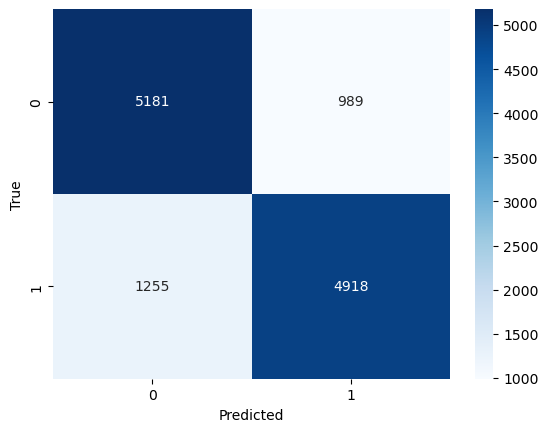

In [15]:
y_predict = modelo.predict(x_test, batch_size=64, verbose=False)
#y_predict_classes = (y_predict > 0.5).astype(int)
y_predict_bool = np.argmax(y_predict, axis=1)

#metricas(y_predict_classes,y_test)
metricas(y_predict_bool,y_test)

Precision: En este caso, la precisión de las clasificaciones de la clase 0 es del 82% y el 81% para clase 1. Lo que quiere decir que el 0.80 del total de las clasificaciones como tipo 0, efectivamente eran de ese tipo, lo mismo para el tipo 1.

Recall: En este caso, el recall para la clase 0 es del 84%. Y vemos que para las instancias de clase 1, el 80% se ha identificado correctamente.

F1-score: El f1-score para la clase 0 es del 0.82, lo que muestra un rendimiento aceptable, tambien un buen score para la clase 1 que es de 0.81.

Exactitud: En este caso, la exactitud general del modelo es del 0.82, lo que indica que el 82% de las predicciones son correctas en general.

### Prediccion Kaggle

In [16]:
if not TESTING: 
    y_predict = modelo.predict(x_predict, verbose=False)
    y_predict_bool = np.argmax(y_predict, axis=1)
    nn_result = pd.DataFrame({'id': ds_test['id'], 'is_canceled': y_predict_bool})
    print(nn_result.head())
    nn_result.to_csv('../predicts/predicts_nn.csv', index=False)